### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 1 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [209]:
a = np.array([1, 2])
a[0:10].mean()

1.5

In [249]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.feature_importances_ = dict()
        self.criterion = criterion
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] < threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __gini_index(self, y):
        distribution = np.unique(y, return_counts=True)[1] / y.size
        return 1 - np.sum(np.square(distribution))

    def __error_index(self, y):
        pk = np.max(np.unique(y, return_counts=True)[1]) / y.size
        return 1 - pk

    def __entropy_index(self, y):
        distribution = np.unique(y, return_counts=True)[1] / y.size
        return -np.sum(distribution * np.log(distribution))

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        if self.criterion == 'gini':
            H = self.__gini_index
        elif self.criterion == 'entropy':
            H = self.__entropy_index
        else:
            H = self.__error_index
        
        target_Q = -1e6
        target_idx, target_trsh = 0, 0
        cur_H = H(y)
        for feature_id in range(x.shape[1]):
            unique_features = np.unique(np.round(x[:, feature_id], 5))
            if unique_features.size == 1:
                continue
            thresholds = ((unique_features[:-1] + unique_features[1:]) / 2)
            divisions = [self.__div_samples(x, y, feature_id, t) for t in thresholds]
            L = np.array([div[2].size * H(div[2]) for div in divisions]) / y.size
            R = np.array([div[3].size * H(div[3]) for div in divisions]) / y.size
            Q = cur_H - L - R
            idx = np.argmax(Q)
            if Q[idx] > target_Q:
                target_Q = Q[idx]
                target_idx, target_trsh = feature_id, thresholds[idx]
        is_leaf = (target_Q == -1e6)
        return target_idx, target_trsh, is_leaf, target_Q

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        def make_leaf(y, node_id):
            labels, counts = np.unique(y, return_counts=True)
            idx, max_count = np.argmax(counts), np.max(counts)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, labels[idx], max_count / y.size)
        
        if y.size >= self.min_samples_split and depth < self.max_depth:
            feature_idx, threshold, is_leaf, gain = self.__find_threshold(x, y)
            if is_leaf:
                make_leaf(y, node_id)
            else:
                self.feature_importances_[feature_idx] += gain                
                x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature_idx, threshold)
                self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_idx, threshold)
                self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
        else:
            make_leaf(y, node_id)
            

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = {i: 0 for i in range(x.shape[1])}
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] < threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_


In [254]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [255]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [256]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [257]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.7777777777777778
0.8888888888888888


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы. 
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [258]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: (0, 1, 2.5), 1: (1, 0, 1.0), 2: (1, 1, 0.7142857142857143)} [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 
		Tree: {0: (0, 1, 2.5), 1: (0, 1, 0.5), 3: (1, 0, 1.0), 4: (1, 0, 1.0), 2: (0, 1, 6.5), 5: (1, 0, 0.5), 6: (1, 1, 1.0)} [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 
		Tree: {0: (0, 1, 2.5), 1: (0, 1, 0.5), 3: (1, 0, 1.0), 4: (0, 1, 1.5), 9: (1, 0, 1.0), 10: (1, 0, 1.0), 2: (0, 1, 6.5), 5: (0, 1, 4.5), 11: (1, 1, 1.0), 12: (1, 0, 1.0), 6: (0, 1, 7.5), 13: (1, 1, 1.0), 14: (1, 1, 1.0)} [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 
		Tree: {0: (0, 1, 2.5), 1: (0, 1, 0.5), 3: (1, 0, 1.0), 4: (0, 1, 1.5), 9: (1, 0, 1.0), 10: (1, 0, 1.0), 2: (0, 1, 6.5), 5: (0, 1, 4.5), 11: (0, 1, 3.5), 23: (1, 1, 1.0), 24: (1, 1, 1.0), 12: (0, 1, 5.5), 25: (1, 0, 1.0), 26: (1, 0, 1.0), 6: (0, 1, 7.5), 13: (1, 1, 1.0), 14: (0, 1, 8.5), 29: (1, 1, 1.0), 30: (1, 1, 1.0)} [0 0 0 0 0 1 1 1 1 1]


### Придумайте интересные примеры для отладки дерева решений (доп. задание)
Это необязательный пункт. За него можно получить 1 доп балл. 
Можете придумать примеры для отладки дерева, похожие на пример выше. 

Они должны быть не сложные, но в то же время информативные, чтобы можно было понять, что реализация содержит ошибки.
Вместе с примером нужно указать ожидаемый выход модели. 

In [259]:
# Примеры

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [260]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


DecisionTreeClassifier()

In [261]:
%time my_clf.fit(X_train, y_train)

Wall time: 643 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [262]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]
    
    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner', 
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise', 
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
    
    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    
    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)
    
    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
                'intel{}_1'.format(i), 'fun{}_1'.format(i), 
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))
    
        df = df.drop(feat, axis=1)
    
    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc. 


In [263]:
data = preprocess_spd_data(pd.read_csv("Speed_Dating_Data.csv", encoding='latin1'))

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [264]:
# Разбиваем на X и y
y = data['match'].values
data.drop(columns='match', inplace=True)
X = data.values

In [265]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [266]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

In [267]:
%%time
# посмотрим, какой impurity лучше
for crit in ('error', 'gini', 'entropy'):
    tree = MyDecisionTreeClassifier(criterion=crit, max_depth=15, min_samples_split=7)
    tree.fit(X_train, y_train)
    print(crit,'-', accuracy_score(y_val, tree.predict(X_val)))

error - 0.8057054741711642
gini - 0.7825751734772552
entropy - 0.7802621434078643
Wall time: 54.7 s


Будем брать misclassification

# Зависимость от глубины

In [268]:
%%time
range_depth = np.arange(1, 20, 2)
scores_train = []
scores_val = []

for depth in range_depth:
    tree = MyDecisionTreeClassifier(max_depth=depth, criterion='error')
    tree.fit(X_train, y_train)
    scores_train.append(accuracy_score(y_train, tree.predict(X_train)))
    scores_val.append(accuracy_score(y_val, tree.predict(X_val)))

Wall time: 2min 29s


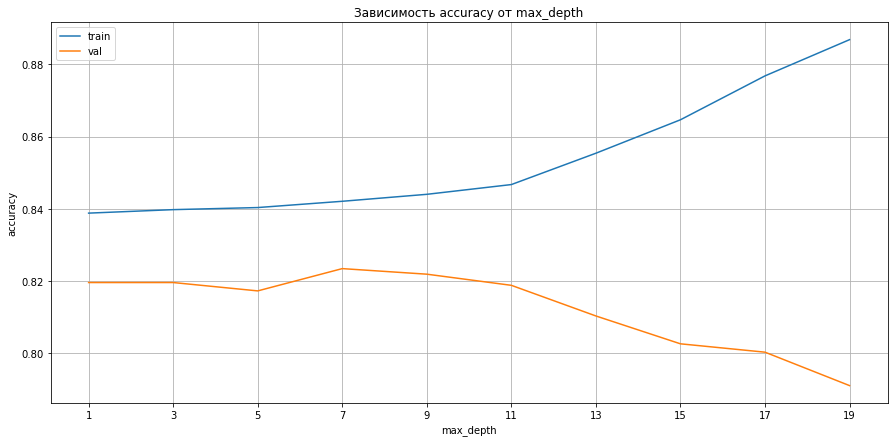

In [269]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.xticks(range_depth)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Зависимость accuracy от max_depth")
plt.plot(range_depth, scores_train, label='train')
plt.plot(range_depth, scores_val, label='val')
plt.legend();

# Зависимость от кол-ва элементов для сплита

In [270]:
%%time
range_n_split = np.arange(2, 30)
scores_train = []
scores_val = []
for n_spllit in range_n_split:
    tree = MyDecisionTreeClassifier(min_samples_split=n_spllit, max_depth=15, criterion='error')
    tree.fit(X_train, y_train)
    scores_train.append(accuracy_score(y_train, tree.predict(X_train)))
    scores_val.append(accuracy_score(y_val, tree.predict(X_val)))

Wall time: 9min 26s


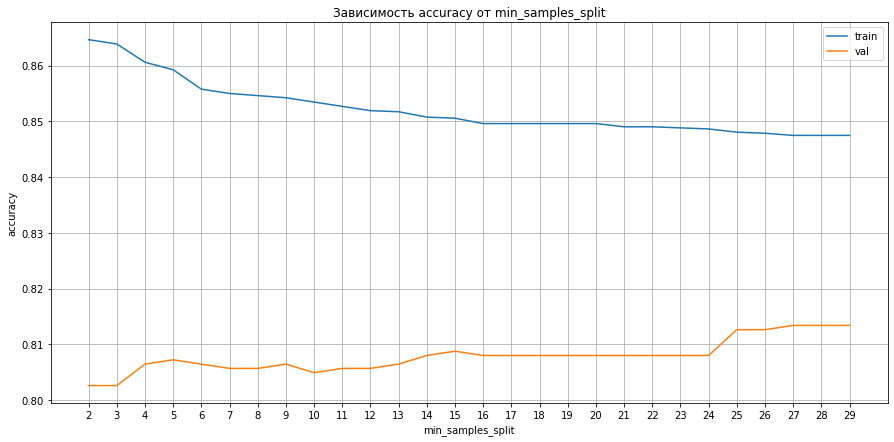

In [271]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.xticks(range_n_split)
plt.title("Зависимость accuracy от min_samples_split")
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.plot(range_n_split, scores_train, label='train')
plt.plot(range_n_split, scores_val, label='val')
plt.legend();

Здесь ситация обратная глубине. Чем выше кол-во для сплита, тем тяжелее алгоритму запомнить выборку, но обобщающая способность растет

# Инференс

Возьму гиперпараметры, в соответствии с эксперементами выше

In [272]:
tree = MyDecisionTreeClassifier(criterion='error', min_samples_split=15, max_depth=7)
tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.8389882788402221

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн. 
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации? 

По графику действительно можно заметить такое поведение, при увелечении глубины выборка запоминается и скор на трейне приближается к 1, в то время как обобщающая способность алгоритма сильно деградирует

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [273]:
most_importance_features = data.columns[np.array(sorted(tree.get_feature_importance().items(),
                                                        key=lambda x: x[-1], reverse=True)[:10], dtype=int)[:, 0]]
for i, name in enumerate(most_importance_features):
    print(i+1,'-', name)

1 - int_corr
2 - exphappy
3 - race
4 - attr1_1
5 - date
6 - attr2_1
7 - pid
8 - iid
9 - amb2_1
10 - imprelig


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Этот ноутбук реально заставляет попотеть! Зато после такого точно будешь хорошо понимать как дерево работает. Вся основная инфа была в лекции. Над некоторыми нюансами голову пришлось поломать, жаль, что так и не получилось ускорить работу, даже с инфой из инета...